<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/neighbourhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import cupy as cp
from cupyx.scipy.special import erf

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import gc
import os
import time
import multiprocessing
from datetime import datetime

##### WARNING #####
##### WARNING #####
##### WARNING ##### IF THE SPECTRAL INDEX N>0, THE SIMULATION SHOULD RUN WITH GRF_64F_PK !!!
##### WARNING ##### IF THE SPECTRAL INDEX N>0, THE SIMULATION SHOULD RUN WITH GRF_64F_PK !!!
##### WARNING ##### IF THE SPECTRAL INDEX N>0, THE SIMULATION SHOULD RUN WITH GRF_64F_PK !!!
##### WARNING ##### IF THE SPECTRAL INDEX N>0, THE SIMULATION SHOULD RUN WITH GRF_64F_PK !!!

In [2]:
# @title 1 GPU simulation

# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field

    def grf_64f_pk(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))
        #print(f"white_noise allocates: {white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise
        #print(f"fft_white_noise allocates: {fft_white_noise.nbytes / (1024**2):.2f} MB of memory.")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        del kx_grid, ky_grid, kz_grid
        #print(f"k_norm allocates: {k_norm.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm
        #print(f"power_spectrum allocates: {power_spectrum.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise
        #print(f"fourier_amplitudes_sqrt allocates: {fourier_amplitudes_sqrt.nbytes / (1024**2):.2f} MB of memory")
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()
        #print(f"gaussian_random_field allocates: {gaussian_random_field.nbytes / (1024**2):.2f} MB of memory")

        # Final estimation of memory usage
        #print(f"Total memory usage: {self.get_process_memory():.2f} MB")

        return gaussian_random_field

    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf

In [4]:
# @title 1.5 paramteres

# full simulation box size
pixel = 2**9

# rectangluar
z_pixel = pixel

# power spectrum
k_power = 3

# threshold exceeding
# s6 = 20, s7 = 27
threshold = 20

# box size
length = 16

# Predefined buffer size for storing data
buffer_size = 10

# Preallocate buffer
save_sub_exprf = cp.zeros((buffer_size, (2 * length + 1) ** 3))


In [ ]:
import time

# index
idx =0

t0 = time.time()

# Initialize an instance of RFSIM
rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0)

while True:
    # Generate a Gaussian random field
    grf = rfsim.grf_64f()  # grf can be _32f or _64f

    ##grf = rfsim.grf_64f_pk()  # grf can be _32f or _64f
    exprf = rfsim.gaussian_to_exp(grf)
    del grf

    if cp.max(exprf)  >= threshold:

        max_pos = cp.unravel_index(cp.argmax(exprf),(pixel,pixel,pixel))

        xmin = max_pos[0] -length
        xmax = max_pos[0] +length +1
        ymin = max_pos[1] -length
        ymax = max_pos[1] +length +1
        zmin = max_pos[2] -length
        zmax = max_pos[2] +length +1

        if xmax < pixel and ymax < pixel and zmax < pixel and xmin > 0 and ymin > 0 and zmin > 0 :
            sub_exprf = exprf[xmin:xmax,ymin:ymax,zmin:zmax].flatten()
            save_sub_exprf[idx] = sub_exprf  # Store the data in the buffer
            idx += 1

            if idx >= buffer_size:
                print(idx, f'time = {t0 - time.time()}')
                t0 = time.time()
                timenow = datetime.now().strftime("%d%H%M%S")

                cp.save(f'sub_exprfs_{buffer_size}_l_{length}_k_{k_power}_{timenow}.npy', save_sub_exprf)

                save_sub_exprf = cp.zeros((buffer_size, (2 * length + 1) ** 3))  # Preallocate buffer
                idx = 0  # Reset the buffer index

            del sub_exprf

    del exprf





In [6]:
import glob
npy_list= glob.glob('*.npy')

In [7]:
npy_list

['sub_exprfs_10_l_16_k_3_07140545.npy',
 'sub_exprfs_10_l_16_k_3_07140145.npy',
 'sub_exprfs_10_l_16_k_3_07140342.npy',
 'sub_exprfs_10_l_16_k_3_07135928.npy']

In [14]:
sas1=np.load('sub_exprfs_10_l_16_k_3_07140145.npy')

In [15]:
print(sas.shape)

print(np.any(sas==0), np.any(np.isnan(sas)) )

(10, 35937)
False False


In [16]:
dsd = np.concatenate(sas)

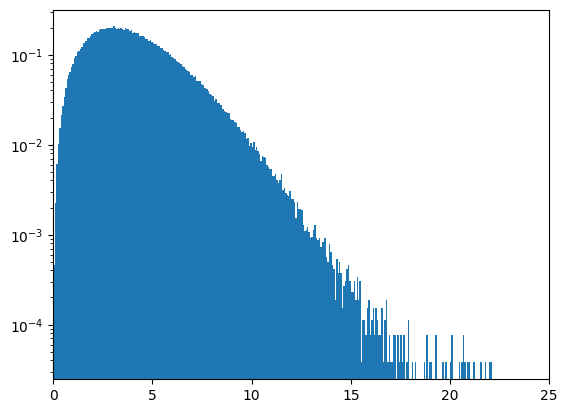

In [19]:
plt.hist(dsd,bins= 301, density=True);
plt.xlim(0,25)
plt.yscale('log')

array([[0.89885966, 3.06948954, 3.37551466, ..., 1.69266515, 1.3187044 ,
        3.50058601],
       [2.54429291, 8.90484194, 1.71031953, ..., 0.79207912, 0.63852435,
        1.69815059],
       [0.11596069, 0.4586646 , 1.97564879, ..., 0.19318393, 0.48947568,
        0.24754315],
       ...,
       [5.65174561, 3.06653097, 0.34403996, ..., 4.63213813, 0.09384742,
        1.83136866],
       [0.43837145, 2.18301812, 1.81608961, ..., 2.64784722, 0.85825901,
        0.41225601],
       [0.52249867, 0.32714801, 1.32513942, ..., 0.99985054, 0.12884797,
        0.51260744]])